# Transformer


Dans ce notebook, nous allons remplacer le LSTM par le transformer.

In [1]:
#!pip install torchtext==0.6.0
#!pip install pytorch-crf

import time
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torchtext.data import Field, NestedField, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from torchcrf import CRF
from collections import Counter
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
from torchcrf import CRF
import numpy as np
import pandas as pd

import time
import math
import random
import string
from itertools import chain

# Préparation des données

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(lower = False) 
TAG = data.Field(unk_token = None) 

my_path = "data_ner/"
train_data, valid_data, test_data = data.TabularDataset.splits(
        path= my_path ,
        train="train.csv",
        validation="valid.csv",
        test="test.csv", format='csv', skip_header=True,
        fields=(("text", TEXT), ("tag", TAG))
    )

MIN_FREQ = 1

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ, # les mots qui apparaissent moins que MIN_FREQ fois seront ignorés du vocabulaire
                 vectors = "glove.6B.300d",
                 unk_init = torch.Tensor.normal_)


TAG.build_vocab(train_data)
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#device = 'cpu'
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device, sort=False)

# padding index
TEXT_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

In [3]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 14986
Number of validation examples: 3465
Number of testing examples: 3683


# Construire le modèle

Pour le modèle transformer, on ajoute une couche fully-connected avec une activation GELU et une autre couche fully-connected qui transforme la dimension de la sortie en nombre correcte de tags possible pour la couche CRF.

Comme nous n'utilisons pas le Transformer complet Encoder-Decoder décrit par [Vaswani et al., 2017](https://arxiv.org/pdf/1706.03762.pdf). Nous n'avons besoin que des encoders, pour "encoder" l'information de chaque token et déterminer s'il s'agit d'une entité. 
On utilise alors les deux modules de PyTorch `TransformerEncoder` and `TransformerEncoderLayer`.

De plus, la classe `PositionalEncoding` provient de la page de tutoriels de PyTorch.
Elle est mentionnée dans l'article de [Devlin et al., 2019](https://arxiv.org/pdf/1810.04805.pdf), on somme alors les embeddings positionnels au embeddings des tokens.

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.6, max_len=700):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class Transformer(nn.Module):

    def __init__(self,
                 input_dim,
                 embedding_dim,
                 attn_heads,
                 fc_hidden,
                 trf_layers,
                 output_dim,
                 emb_dropout,
                 trf_dropout,
                 fc_dropout,
                 word_pad_idx,
                 tag_pad_idx):  
        super().__init__()
        
        self.word_pad_idx = word_pad_idx
        self.tag_pad_idx = tag_pad_idx

        # LAYER 1: Word Embedding
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim= embedding_dim,
            padding_idx=word_pad_idx
        )

        self.emb_dropout = nn.Dropout(emb_dropout)
        
        # LAYER 2: Transformer
        all_emb_size = embedding_dim 
        self.position_encoder = PositionalEncoding(
            d_model=all_emb_size
        )
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=all_emb_size,
            nhead=attn_heads,
            activation="relu",
            dropout=trf_dropout
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layers,
            num_layers=trf_layers
        )
        
        # LAYER 3: 2-couches fully-connected avec GELU activation 
        self.fc1 = nn.Linear(
            in_features=all_emb_size,
            out_features=fc_hidden
        )
        self.fc1_gelu = nn.GELU()
        self.fc1_norm = nn.LayerNorm(fc_hidden)
        self.fc2_dropout = nn.Dropout(fc_dropout)
        self.fc2 = nn.Linear(
            in_features=fc_hidden,
            out_features=output_dim
        )

        # LAYER 4: CRF
        self.crf = CRF(num_tags=output_dim)
        
        # init poids distribution normale 
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, words, tags=None):
        # words = [sentence length, batch size]
        # chars = [batch size, sentence length, word length)
        # tags = [sentence length, batch size]

        # embedding_out = [sentence length, batch size, embedding dim]
        embedding_out = self.emb_dropout(self.embedding(words))

        # Transformer
        key_padding_mask = torch.as_tensor(words == self.word_pad_idx).permute(1, 0)
        
        # pos_out = [sentence length, batch size, embedding dim + char emb dim * num filter]
        pos_out = self.position_encoder(embedding_out)
        # enc_out = [sentence length, batch size, embedding dim + char emb dim * num filter]
        enc_out = self.encoder(pos_out, src_key_padding_mask=key_padding_mask)
        # Fully-connected
        # fc1_out = [sentence length, batch size, fc hidden]
        fc1_out = self.fc1_norm(self.fc1_gelu(self.fc1(enc_out)))
        # fc2_out = [sentence length, batch size, output dim]
        fc2_out = self.fc2(self.fc2_dropout(fc1_out))
     
        # CRF    
        crf_mask = words != self.word_pad_idx
        crf_out = self.crf.decode(fc2_out, mask=crf_mask)
        crf_loss = -self.crf(fc2_out, tags=tags, mask=crf_mask) if tags is not None else None
        return crf_out, crf_loss
        
    
    def init_crf_transitions(self, tag_names, imp_value=-100):
        num_tags = len(tag_names)
        for i in range(num_tags):
            tag_name = tag_names[i]
            # I and <pad> impossible as a start
            if tag_name[0] == "I" or tag_name[0] == "<pad>":
                torch.nn.init.constant_(self.crf.start_transitions[i], imp_value)
        # init impossible transitions between positions
        tag_is = {}
        for tag_position in ("B", "I", "O"):
            tag_is[tag_position] = [i for i, tag in enumerate(tag_names) if tag[0] == tag_position]
        impossible_transitions_position = {
            "O": "I"
        }
        for from_tag, to_tag_list in impossible_transitions_position.items():
            to_tags = list(to_tag_list)
            
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                    
                        torch.nn.init.constant_(
                            self.crf.transitions[from_tag_i, to_tag_i], imp_value
                        )
        # init impossible B and I transitions to different entity types
        impossible_transitions_tags = {
            "B": "I",
            "I": "I"
        }
        for from_tag, to_tag_list in impossible_transitions_tags.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        if tag_names[from_tag_i].split("-")[1] != tag_names[to_tag_i].split("-")[1]:
                            torch.nn.init.constant_(
                                self.crf.transitions[from_tag_i, to_tag_i], imp_value
                            )

        
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [5]:
model = Transformer(
    input_dim = len(TEXT.vocab),
    embedding_dim = 300,
    attn_heads = 4,  
    fc_hidden = 64,  
    trf_layers = 1,
    output_dim = len(TAG.vocab),
    emb_dropout = 0.2,
    trf_dropout = 0.2,
    fc_dropout = 0.5,
    word_pad_idx=TEXT_PAD_IDX,
    tag_pad_idx=TAG_PAD_IDX,
)
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[TAG_PAD_IDX] = torch.zeros(300)

# CRF transitions initialisation
model.init_crf_transitions(
    tag_names = TAG.vocab.itos
)
print(f"Le modèle a {model.count_parameters():,} paramètres à entraîner.")

Le modèle a 8,701,510 paramètres à entraîner.


# Entraînement


In [6]:
def optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

#optimizer = optimiseur(model, lr=1e-5, eps=1e-7, weight_decay_rate=0.001, second_weight_decay_rate=0.0)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

model = model.to(device)
criterion = criterion.to(device)

In [7]:
from sklearn.metrics import f1_score, classification_report

def f1_loss( preds, y, tag_pad_idx, full_report=False):
    index_o = TAG.vocab.stoi["O"]
    positive_labels = [i for i in range(len(TAG.vocab.itos))
                       if i not in (tag_pad_idx, index_o)]

    flatten_preds = [pred for sent_pred in preds for pred in sent_pred]

    positive_preds = [pred for pred in flatten_preds
                      if pred not in (tag_pad_idx, index_o)]

    flatten_y = [tag for sent_tag in y for tag in sent_tag]
    if full_report:
      
        positive_names = [TAG.vocab.itos[i]
                              for i in range(len(TAG.vocab.itos))
                              if i not in (tag_pad_idx, index_o)]
        print(classification_report(
                y_true=flatten_y,
                y_pred=flatten_preds,
                labels=positive_labels,
                target_names=positive_names
            ))

    return f1_score(
            y_true=flatten_y,
            y_pred=flatten_preds,
            labels=positive_labels,
            average="micro"
        ), flatten_preds, flatten_y

In [8]:
def train(model, iterator, optimizer, tag_pad_idx):
    
    epoch_loss = 0
    epoch_f1 = 0    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.tag
      
        optimizer.zero_grad()

        pred_tags_list, batch_loss = model(text, tags)
        
        # pour calculer la loss et le score f1, on flatten true tags
        true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
            ]
        f1,_,_ = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx)

        batch_loss.backward()
        
        optimizer.step()
        epoch_loss += batch_loss.item()
        epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator)

def evaluate(model, iterator, tag_pad_idx,full_report):
    
    epoch_loss = 0
    epoch_f1 = 0
    
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.tag
        
            pred_tags_list, batch_loss = model(text, tags)
            true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
                ]
            
            f1, pred, lab = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx, full_report)
            preds.append(pred)
            labels.append(lab)
            epoch_loss += batch_loss.item()
            epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator),preds, labels

In [9]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 50

t_loss = []
t_f1 = []
v_loss = []
v_f1 = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
   
    
    train_loss, train_f1 = train(model, train_iterator, optimizer, TAG_PAD_IDX)
    t_loss.append(train_loss)
    t_f1.append(train_f1) 
    
    valid_loss, valid_f1,_,_ = evaluate(model, valid_iterator, TAG_PAD_IDX, full_report= False)
    v_loss.append(valid_loss)
    v_f1.append(valid_f1)
    
    #scheduler.step()
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model_conll.pt')
    

    if epoch%10 == 0: 
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 654.996 | Train F1 score: 0.24%
	 Val. Loss: 640.762 |  Val. F1 score: 0.00%
Epoch: 11 | Epoch Time: 0m 21s
	Train Loss: 196.292 | Train F1 score: 46.19%
	 Val. Loss: 889.743 |  Val. F1 score: 20.38%
Epoch: 21 | Epoch Time: 0m 21s
	Train Loss: 134.153 | Train F1 score: 64.02%
	 Val. Loss: 757.669 |  Val. F1 score: 42.27%
Epoch: 31 | Epoch Time: 0m 21s
	Train Loss: 93.506 | Train F1 score: 75.90%
	 Val. Loss: 699.157 |  Val. F1 score: 52.66%
Epoch: 41 | Epoch Time: 0m 21s
	Train Loss: 68.017 | Train F1 score: 82.73%
	 Val. Loss: 630.050 |  Val. F1 score: 60.84%


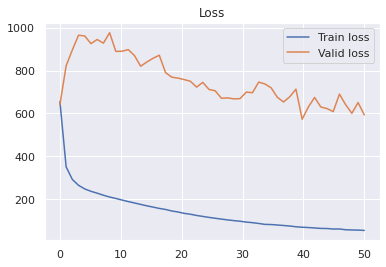

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_loss)
plt.plot(x,v_loss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

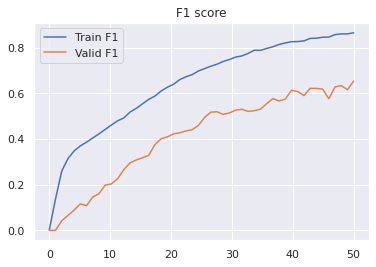

In [11]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_f1)
plt.plot(x,v_f1)
plt.title("F1 score")
plt.legend(["Train F1", "Valid F1"])

In [12]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
model.load_state_dict(torch.load('tut5-model_conll.pt'))

test_loss, test_f1, preds, labels = evaluate(model, test_iterator, TAG_PAD_IDX, full_report=False)
print(f'Test Loss: {test_loss:.3f} |  Test F1 score: {test_f1*100:.2f}%')

Test Loss: 678.936 |  Test F1 score: 54.77%


In [13]:
predict =  [item for sublist in preds for item in sublist]
true =  [item for sublist in labels for item in sublist]
confusion = confusion_matrix(true, predict)

### Matrice de confusion

In [16]:
confusion_df =pd.DataFrame(confusion)

confusion_df.columns=[i for i in TAG.vocab.itos][1:]
s = pd.Series([i for i in TAG.vocab.itos][1:])
confusion_df = confusion_df.set_index([s])

confusion_df['LOC'] = confusion_df['B-LOC'] + confusion_df['I-LOC']
confusion_df['PER'] = confusion_df['B-PER'] + confusion_df['I-PER']
confusion_df['ORG'] = confusion_df['B-ORG'] + confusion_df['I-ORG']
confusion_df['MISC'] = confusion_df['B-MISC'] + confusion_df['I-MISC']


confusion_df = confusion_df.drop(columns=[ i for i in TAG.vocab.itos if i != 'O' and i != '<pad>'])

confusion_df.loc['LOC'] = confusion_df.loc['B-LOC'] + confusion_df.loc['I-LOC']
confusion_df.loc['PER'] = confusion_df.loc['B-PER'] + confusion_df.loc['I-PER']
confusion_df.loc['ORG'] = confusion_df.loc['B-ORG'] + confusion_df.loc['I-ORG']
confusion_df.loc['MISC'] = confusion_df.loc['B-MISC'] + confusion_df.loc['I-MISC']

confusion_df = confusion_df.drop([i for i in TAG.vocab.itos if i != 'O' and i != '<pad>'])

confusion_df

,O,LOC,PER,ORG,MISC
O,38435,21,3,19,42
LOC,406,1441,1,56,20
PER,2317,29,402,21,3
ORG,1076,265,21,1069,63
MISC,352,11,8,13,531


### Precision-Recall-F1Score

In [17]:
cm = confusion_df.to_numpy()

TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP

num_classes = 4
TN = []
for i in range(num_classes):
    temp = np.delete(cm, i, 0)    
    temp = np.delete(temp, i, 1) 
    TN.append(sum(sum(temp)))
    
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

prf_df =pd.DataFrame()
prf_df['Precision'] = precision
prf_df['Recall'] = recall
prf_df['F1-score'] = f1

s = pd.Series([i for i in confusion_df.index])
prf_df = prf_df.set_index([s])

prf_df

,Precision,Recall,F1-score
O,0.902527,0.997793,0.947772
LOC,0.815507,0.748960,0.780818
PER,0.924138,0.145022,0.250702
ORG,0.907470,0.428629,0.582244
MISC,0.805766,0.580328,0.674714


In [18]:
def tag_sentence(model, device, sentence, text_field, tag_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    max_word_len = max([len(token) for token in tokens])
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]
    unk_idx = text_field.vocab.stoi[text_field.unk_token]  
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
    predictions, _ = model(token_tensor)
    predicted_tags = [tag_field.vocab.itos[t] for t in predictions[0]]
    
    return tokens, predicted_tags, unks

In [19]:
example_index = 15

sentence = vars(test_data.examples[example_index])['text']
actual_tags = vars(test_data.examples[example_index])['tag']

print(sentence)
tokens, pred_tags, unks = tag_sentence(model, 
                                       device, 
                                       sentence, 
                                       TEXT, 
                                       TAG
                                       )

print("Pred. Tag\t\t\t\tActual Tag\t\t\t\tCorrect?\t\t\t\tToken\n")
for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    space = 5 if pred_tag == 'O'else 4
    space1 = 5 if actual_tag == 'O'else 4   
    print(pred_tag,"\t"*space, actual_tag, "\t"*space1, correct,"\t"*5, token)

['Japan', 'then', 'laid', 'siege', 'to', 'the', 'Syrian', 'penalty', 'area', 'for', 'most', 'of', 'the', 'game', 'but', 'rarely', 'breached', 'the', 'Syrian', 'defence', '.']
Pred. Tag				Actual Tag				Correct?				Token

B-LOC 				 B-LOC 				 ✔ 					 Japan
O 					 O 					 ✔ 					 then
O 					 O 					 ✔ 					 laid
O 					 O 					 ✔ 					 siege
O 					 O 					 ✔ 					 to
O 					 O 					 ✔ 					 the
B-MISC 				 B-MISC 				 ✔ 					 Syrian
O 					 O 					 ✔ 					 penalty
O 					 O 					 ✔ 					 area
O 					 O 					 ✔ 					 for
O 					 O 					 ✔ 					 most
O 					 O 					 ✔ 					 of
O 					 O 					 ✔ 					 the
O 					 O 					 ✔ 					 game
O 					 O 					 ✔ 					 but
O 					 O 					 ✔ 					 rarely
O 					 O 					 ✔ 					 breached
O 					 O 					 ✔ 					 the
B-MISC 				 B-MISC 				 ✔ 					 Syrian
O 					 O 					 ✔ 					 defence
O 					 O 					 ✔ 					 .


In [21]:
sentence = 'The will deliver a speech about the conflict in North Korea tomorrow in New York with my friend Mary Kate.'
tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence, 
                                  TEXT, 
                                  TAG
                                )

print(unks)
print("Pred. Tag\tToken\n")


for token, tag in zip(tokens, tags):
    space = 2 if tag == 'O'else 1
    print(tag, "\t"*space, token)

[]
Pred. Tag	Token

O 		 The
O 		 will
O 		 deliver
O 		 a
O 		 speech
O 		 about
O 		 the
O 		 conflict
O 		 in
B-LOC 	 North
I-LOC 	 Korea
O 		 tomorrow
O 		 in
B-LOC 	 New
I-LOC 	 York
O 		 with
O 		 my
O 		 friend
O 		 Mary
O 		 Kate
O 		 .
